##  Python framework with modular function that takes the target images and generates a histogram for each target file and compares to each set of scene images (and the test files). 

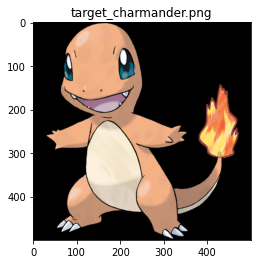

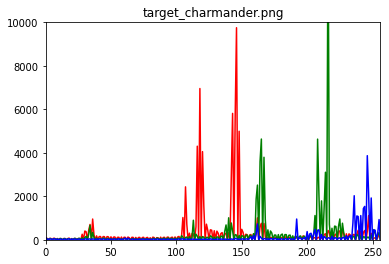

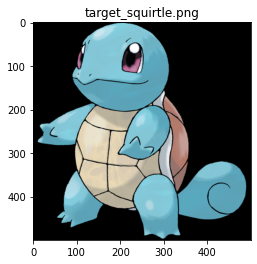

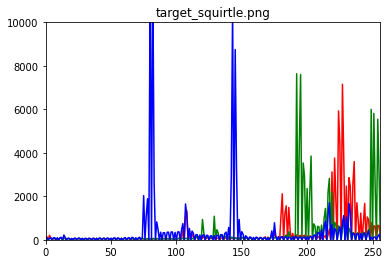

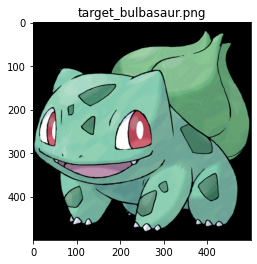

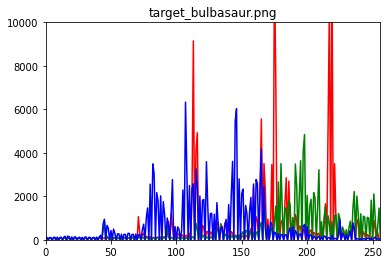

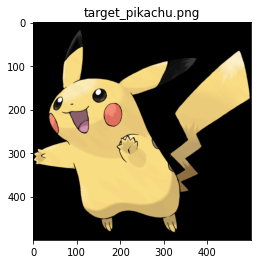

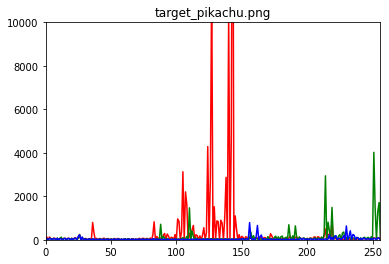

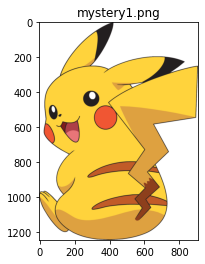

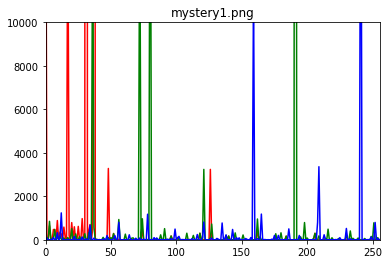

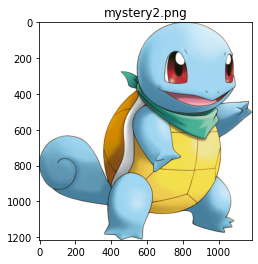

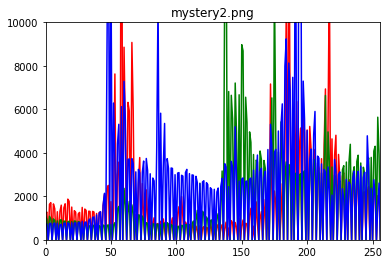

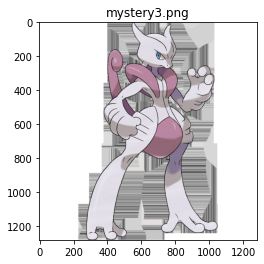

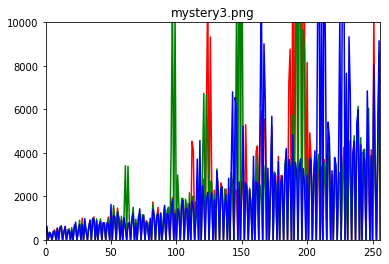

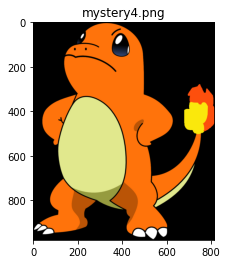

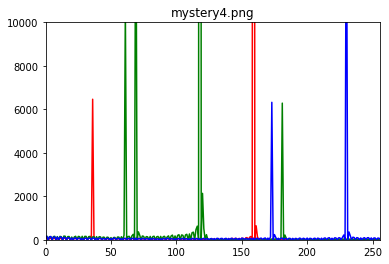

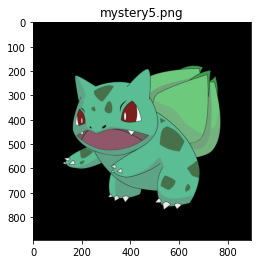

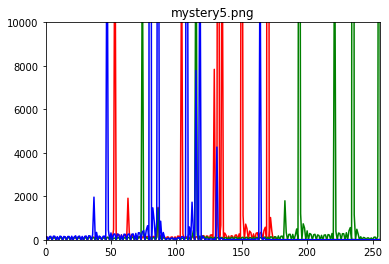

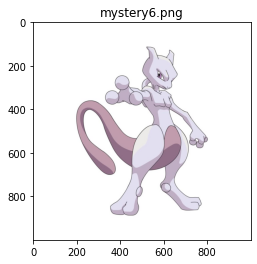

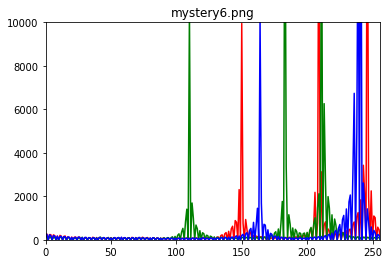

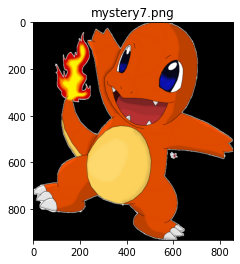

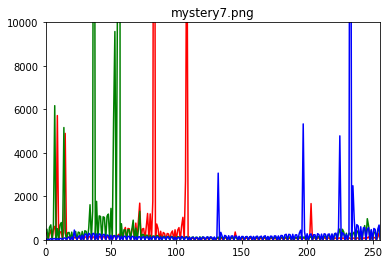

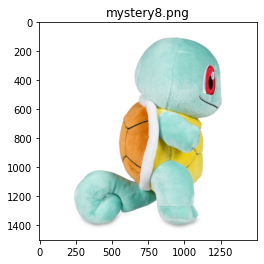

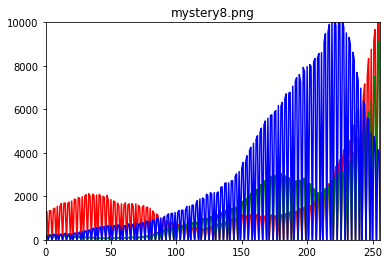

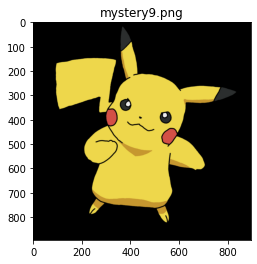

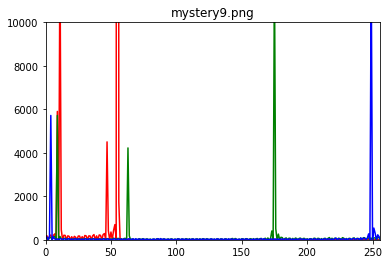

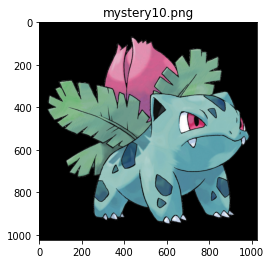

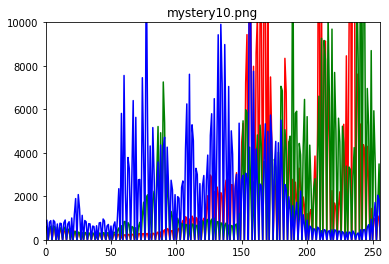

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import shutil
import argparse
import glob
import cv2
import os
import pathlib
import pprint 

def conv_image_files(image_path,conversion=cv2.COLOR_BGR2RGB):   
    image_list = [(os.path.basename(f),cv2.imread(f,conversion)) for f in image_path]
    image_dict = {file:image for (file,image) in image_list}
    return image_dict

def generate_histogram(image_dict, bins=288, l_pix = 20,h_pix = 240):
    histogram_dict = dict()
    for filename in image_dict:
        image = image_dict[filename]
        hist = cv2.calcHist([image], [0,1,2], None, [bins,bins,bins], [l_pix, h_pix, l_pix, h_pix, l_pix, h_pix])
        overall_hist = np.concatenate(hist).ravel()
        hist = overall_hist /overall_hist.sum()
        #hist = cv2.normalize(hist, hist).flatten()
        histogram_dict[filename] = hist
    return histogram_dict

def class_matcher (image_files, matchers):
    comp1 = [s for s in image_files if any(xs in s for xs in matchers)]
    return comp1

def plotting_hist(images,query):    
    plt.imshow(cv2.cvtColor(images[query], cv2.COLOR_BGR2RGB))
    plt.title(query)
    plt.show()
    color = ('r','g','b')
    
    for i,col in enumerate(color):
        hist = cv2.calcHist([images[query]],[i],None,[300],[40,230])
        plt.plot(hist,color = col)
        plt.xlim([0,256])
        plt.ylim([0,10000])
        plt.title(query)
    plt.show()
    return

def calculate_cdf(histogram):

    # Get the cumulative sum of the elements
    cdf = histogram.cumsum()
 
    # Normalize the cdf
    normalized_cdf = cdf / float(cdf.max())
 
    return normalized_cdf

def list_zipper(query_images, target_comp):
    y = len(query_images)
    output = [target_comp[:] for i in range(y)]
    for i in range(y):
        output[i].append(query_images[i])
        #output[i] = {key: i for i, key in enumerate(out[i])}
    return output

image_path = 'HistogramDataset/'
image_files = glob.glob(image_path + '/**/*.png', recursive=True)

targets_matchers = ['targets']
mystery_matchers = ['mystery']
classes_matchers_p = ['classes/pikachu']
classes_matchers_c = ['classes/charmander']
classes_matchers_s = ['classes/squirtle']
classes_matchers_b = ['classes/bulbasaur']

target_images = class_matcher(image_files,targets_matchers)
mystery_images = class_matcher(image_files,mystery_matchers)

#data set training 
pikachu_image = class_matcher(image_files,classes_matchers_p)
pikachu_image.append(target_images[1])
charmander_image = class_matcher(image_files,classes_matchers_c)
charmander_image.append(target_images[3])
squirtle_image = class_matcher(image_files,classes_matchers_s)
squirtle_image.append(target_images[0])
bulbasaur_image = class_matcher(image_files,classes_matchers_b) 
bulbasaur_image.append(target_images[2])

target_dic = conv_image_files(target_images)
mystery_dic = conv_image_files(mystery_images)

pikachu_dic = conv_image_files(pikachu_image)
charmander_dic = conv_image_files(charmander_image)
squirtle_dic = conv_image_files(squirtle_image)
bulbasaur_dic = conv_image_files(bulbasaur_image)

target_hist = generate_histogram(target_dic)
mystery_hist =  generate_histogram(mystery_dic)

pikachu_hist = generate_histogram(pikachu_dic)
charmander_hist =generate_histogram(charmander_dic)
squirtle_hist =generate_histogram(squirtle_dic)
bulbasaur_hist =generate_histogram(bulbasaur_dic)

plotting_hist(target_dic,'target_charmander.png')
plotting_hist(target_dic,'target_squirtle.png')
plotting_hist(target_dic,'target_bulbasaur.png')
plotting_hist(target_dic,'target_pikachu.png')
plotting_hist(mystery_dic,'mystery1.png')
plotting_hist(mystery_dic,'mystery2.png')
plotting_hist(mystery_dic,'mystery3.png')
plotting_hist(mystery_dic,'mystery4.png')
plotting_hist(mystery_dic,'mystery5.png')
plotting_hist(mystery_dic,'mystery6.png')
plotting_hist(mystery_dic,'mystery7.png')
plotting_hist(mystery_dic,'mystery8.png')
plotting_hist(mystery_dic,'mystery9.png')
plotting_hist(mystery_dic,'mystery10.png')




In [55]:
OPENCV_METHODS = (
        ("Correlation", cv2.HISTCMP_CORREL),
        ("Chi-Squared", cv2.HISTCMP_CHISQR),
        ("Intersection", cv2.HISTCMP_INTERSECT),
        ("Hellinger", cv2.HISTCMP_BHATTACHARYYA))

In [56]:
def search(classes, query):
    method_results = {}
    for position,(methodName, method) in enumerate(OPENCV_METHODS):
        # initialize the results dictionary and the sort
        # direction
        results = {}
        reverse = False

        # if we are using the correlation or intersection
        # method, then sort the results in reverse order
        if methodName in ("Correlation", "Intersection"):
                reverse = True

        # loop over the index
        
        for (k, hist) in classes.items():
                # compute the distance between the two histograms
                # using the method and update the results dictionary
                d = cv2.compareHist(classes[query], hist, method)
                results[k] = d
                
                #print(results)
        # sort the results
        results = sorted([(v, k) for (k, v) in results.items()], reverse = reverse) 
        method_results[methodName]=results
        
    return method_results

In [57]:
#['HistogramDataset/targets/target_squirtle.png', 'HistogramDataset/targets/target_pikachu.png', 
#'HistogramDataset/targets/target_bulbasaur.png', 'HistogramDataset/targets/target_charmander.png']


train_compare= {**target_hist,**mystery_hist}



train_pikachu = search(pikachu_hist,"target_pikachu.png")
train_squirtle = search(squirtle_hist,"target_squirtle.png")
train_charmander = search(charmander_hist,"target_charmander.png")
train_bulbasaur = search(bulbasaur_hist,"target_bulbasaur.png")

train_mystery_pikachu  =  search(train_compare,"target_pikachu.png")
train_mystery_squirtle =  search(train_compare,"target_squirtle.png")
train_mystery_charmander =  search(train_compare,"target_charmander.png")
train_mystery_bulbasaur =  search(train_compare,"target_bulbasaur.png")


#"Correlation"
#"Chi-Squared"
#"Intersection"
#"Hellinger"

print(train_pikachu["Correlation"])
      

[(1.0, 'target_pikachu.png'), (0.0018090297587278756, 'pikachu3.png'), (0.00070767600790425, 'pikachu1.png'), (-9.060592791709873e-05, 'pikachu4.png'), (-0.00011422861138096444, 'pikachu9.png'), (-0.00012735210201216248, 'pikachu10.png'), (-0.0001435257015670344, 'pikachu5.png'), (-0.0005786275200234159, 'pikachu8.png'), (-0.0012939871700960448, 'pikachu2.png'), (-0.0015740925876676708, 'pikachu7.png'), (-0.003735890023834471, 'pikachu6.png')]


In [68]:
import pprint
#pp = pprint.PrettyPrinter(indent=3) # adjust to your liking


#pp.pprint(train_mystery_pikachu["Correlation"])
#pp.pprint(train_mystery_pikachu["Chi-Squared"])
#pp.pprint(train_mystery_pikachu["Intersection"])
#pp.pprint(train_mystery_pikachu["Hellinger"])


In [122]:
mystery_vs_target_list = list_zipper(mystery_images, target_images)
mystery_vs_target_dic = conv_image_files(mystery_vs_target_list[1])
mystery_vs_target_hist = generate_histogram(mystery_vs_target_dic)
#print(mystery_vs_target_dic)
mystery_score =  search(mystery_vs_target_hist,"mystery2.png")
pp = pprint.PrettyPrinter(indent=3) # adjust to your liking
pp.pprint(mystery_score["Correlation"])
pp.pprint(mystery_score["Chi-Squared"])
pp.pprint(mystery_score["Intersection"])
pp.pprint(mystery_score["Hellinger"])

m_name = ["Correlation","Chi-Squared","Intersection","Hellinger"]


[  (1.0, 'mystery2.png'),
   (2.5605015038366226e-05, 'target_bulbasaur.png'),
   (8.027976668489936e-06, 'target_pikachu.png'),
   (-1.1086399159894686e-06, 'target_squirtle.png'),
   (-1.2073093594199547e-06, 'target_charmander.png')]
[  (0.0, 'mystery2.png'),
   (1.2755111019771317, 'target_charmander.png'),
   (1.6329456646416387, 'target_squirtle.png'),
   (17.29933040977192, 'target_pikachu.png'),
   (62.18665530230813, 'target_bulbasaur.png')]
[  (0.9999999945689524, 'mystery2.png'),
   (0.0019689503133122344, 'target_bulbasaur.png'),
   (0.001924792211411841, 'target_pikachu.png'),
   (0.0017561021154506307, 'target_squirtle.png'),
   (0.0010978737013829232, 'target_charmander.png')]
[  (0.0, 'mystery2.png'),
   (0.997769162724473, 'target_pikachu.png'),
   (0.9978598230105348, 'target_bulbasaur.png'),
   (0.9980433873311462, 'target_squirtle.png'),
   (0.9985444992275674, 'target_charmander.png')]
4


In [82]:
#mystery= cv2.merge([target_hist, mystery_hist[0]])
#target_hist.update(mystery_hist)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


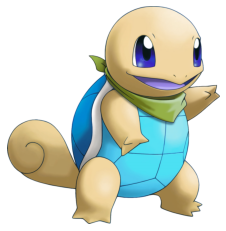

<Figure size 30000x30000 with 0 Axes>

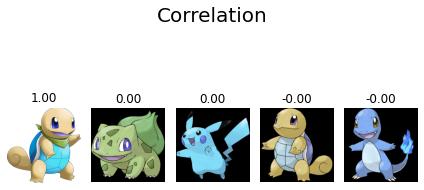

In [141]:
fig = plt.figure("Query")        
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mystery_vs_target_dic["mystery2.png"])
plt.axis("off")
# initialize the results figure
fig=plt.figure(figsize=(200,200),dpi=150)
fig = plt.figure("Results:")
fig.suptitle(m_name[0], fontsize = 20)
for (i, (v, k)) in enumerate(mystery_score["Correlation"]):
        # show the result
    ax = fig.add_subplot(1, len(mystery_vs_target_dic), i + 1)
            
    ax.set_title("%.2f" % ( v))
    plt.imshow(mystery_vs_target_dic[k])
    plt.tight_layout(pad=400)
    plt.axis("off")
    plt.tight_layout()
# show the OpenCV methods
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  from ipykernel import kernelapp as app


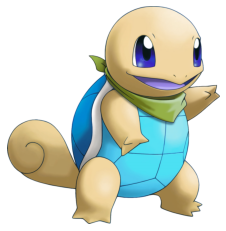

<Figure size 30000x30000 with 0 Axes>

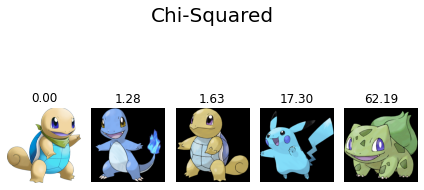

In [143]:
fig = plt.figure("Query")        
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mystery_vs_target_dic["mystery2.png"])
plt.axis("off")
# initialize the results figure
fig=plt.figure(figsize=(200,200),dpi=150)
fig = plt.figure("Results:")
fig.suptitle(m_name[1], fontsize = 20)
for (i, (v, k)) in enumerate(mystery_score["Chi-Squared"]):
        # show the result
    ax = fig.add_subplot(1, len(mystery_vs_target_dic), i + 1)
            
    ax.set_title("%.2f" % ( v))
    plt.imshow(mystery_vs_target_dic[k])
    plt.tight_layout(pad=400)
    plt.axis("off")
    plt.tight_layout()
# show the OpenCV methods
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  from ipykernel import kernelapp as app


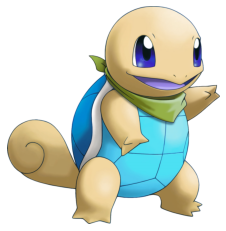

<Figure size 30000x30000 with 0 Axes>

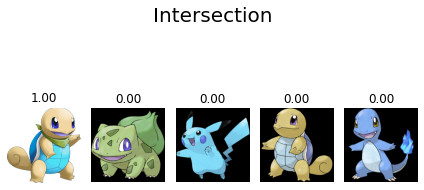

In [146]:
fig = plt.figure("Query")        
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mystery_vs_target_dic["mystery2.png"])
plt.axis("off")
# initialize the results figure
fig=plt.figure(figsize=(200,200),dpi=150)
fig = plt.figure("Results:")
fig.suptitle(m_name[2], fontsize = 20)
for (i, (v, k)) in enumerate(mystery_score["Intersection"]):
        # show the result
    ax = fig.add_subplot(1, len(mystery_vs_target_dic), i + 1)
            
    ax.set_title("%.2f" % ( v))
    plt.imshow(mystery_vs_target_dic[k])
    plt.tight_layout(pad=400)
    plt.axis("off")
    plt.tight_layout()
# show the OpenCV methods
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  from ipykernel import kernelapp as app


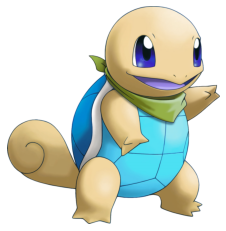

<Figure size 30000x30000 with 0 Axes>

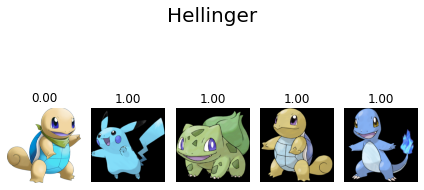

In [152]:
fig = plt.figure("Query")        
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mystery_vs_target_dic["mystery2.png"])
plt.axis("off")
# initialize the results figure
fig=plt.figure(figsize=(200,200),dpi=150)
fig = plt.figure("Results:")
fig.suptitle(m_name[3], fontsize = 20)
for (i, (v, k)) in enumerate(mystery_score["Hellinger"]):
        # show the result
    ax = fig.add_subplot(1, len(mystery_vs_target_dic), i + 1)
            
    ax.set_title("%.2f" % ( v))
    plt.imshow(mystery_vs_target_dic[k])
    plt.tight_layout(pad=400)
    plt.axis("off")
    plt.tight_layout()
# show the OpenCV methods
plt.show()

In [157]:
mystery_vs_target_list = list_zipper(mystery_images, target_images)
mystery_vs_target_dic = conv_image_files(mystery_vs_target_list[4])
mystery_vs_target_hist = generate_histogram(mystery_vs_target_dic)

In [158]:
print(mystery_vs_target_hist)

{'target_squirtle.png': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'target_pikachu.png': array([0.00081341, 0.0008586 , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32), 'target_bulbasaur.png': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'target_charmander.png': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'mystery5.png': array([1.1553125e-05, 3.8510416e-06, 0.0000000e+00, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)}


In [160]:
#mystery10.png

mystery_score =  search(mystery_vs_target_hist,"mystery5.png")
pp.pprint(mystery_score["Correlation"])
pp.pprint(mystery_score["Chi-Squared"])
pp.pprint(mystery_score["Intersection"])
pp.pprint(mystery_score["Hellinger"])

[  (1.0, 'mystery5.png'),
   (9.847018078713579e-06, 'target_bulbasaur.png'),
   (2.8083108446751173e-06, 'target_pikachu.png'),
   (-1.0293578547398518e-06, 'target_charmander.png'),
   (-1.4680175033727928e-06, 'target_squirtle.png')]
[  (0.0, 'mystery5.png'),
   (1.0000617018858549, 'target_squirtle.png'),
   (1.000466752068225, 'target_charmander.png'),
   (1.1217396501861543, 'target_bulbasaur.png'),
   (9.564627983213002, 'target_pikachu.png')]
[  (1.0000000205473043, 'mystery5.png'),
   (0.0029229869705886813, 'target_bulbasaur.png'),
   (0.0008664843680890044, 'target_pikachu.png'),
   (9.969965594791574e-05, 'target_charmander.png'),
   (7.773236211505719e-05, 'target_squirtle.png')]
[  (0.0, 'mystery5.png'),
   (0.9973521020820189, 'target_bulbasaur.png'),
   (0.9981376394288899, 'target_pikachu.png'),
   (0.9999075784142447, 'target_charmander.png'),
   (0.9999464829837943, 'target_squirtle.png')]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  from ipykernel import kernelapp as app


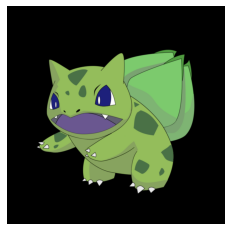

<Figure size 30000x30000 with 0 Axes>

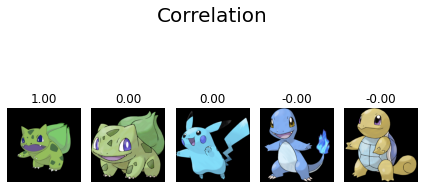

In [161]:
fig = plt.figure("Query")        
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mystery_vs_target_dic["mystery5.png"])
plt.axis("off")
# initialize the results figure
fig=plt.figure(figsize=(200,200),dpi=150)
fig = plt.figure("Results:")
fig.suptitle(m_name[0], fontsize = 20)
for (i, (v, k)) in enumerate(mystery_score["Correlation"]):
        # show the result
    ax = fig.add_subplot(1, len(mystery_vs_target_dic), i + 1)
            
    ax.set_title("%.2f" % ( v))
    plt.imshow(mystery_vs_target_dic[k])
    plt.tight_layout(pad=400)
    plt.axis("off")
    plt.tight_layout()
# show the OpenCV methods
plt.show()

In [166]:
mystery_vs_target_list = list_zipper(mystery_images, target_images)
mystery_vs_target_dic = conv_image_files(mystery_vs_target_list[7])
mystery_vs_target_hist = generate_histogram(mystery_vs_target_dic)
print(mystery_vs_target_hist)

{'target_squirtle.png': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'target_pikachu.png': array([0.00081341, 0.0008586 , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32), 'target_bulbasaur.png': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'target_charmander.png': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'mystery1.png': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}


In [167]:
mystery_score =  search(mystery_vs_target_hist,"mystery1.png")
pp = pprint.PrettyPrinter(indent=3) # adjust to your liking
pp.pprint(mystery_score["Correlation"])
pp.pprint(mystery_score["Chi-Squared"])
pp.pprint(mystery_score["Intersection"])
pp.pprint(mystery_score["Hellinger"])

[  (1.0, 'mystery1.png'),
   (5.834741854249785e-07, 'target_pikachu.png'),
   (-7.92407569619405e-07, 'target_charmander.png'),
   (-9.118074821517986e-07, 'target_squirtle.png'),
   (-1.3905906502989262e-06, 'target_bulbasaur.png')]
[  (0.0, 'mystery1.png'),
   (0.9998258215874349, 'target_pikachu.png'),
   (0.9999667694005961, 'target_squirtle.png'),
   (1.0000000142154022, 'target_bulbasaur.png'),
   (1.0000000142154022, 'target_charmander.png')]
[  (1.0000000142154022, 'mystery1.png'),
   (9.037913696374744e-05, 'target_pikachu.png'),
   (1.6827227227622643e-05, 'target_squirtle.png'),
   (0.0, 'target_charmander.png'),
   (0.0, 'target_bulbasaur.png')]
[  (0.0, 'mystery1.png'),
   (0.9998323247069416, 'target_pikachu.png'),
   (0.9999460764427469, 'target_squirtle.png'),
   (1.0, 'target_bulbasaur.png'),
   (1.0, 'target_charmander.png')]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  from ipykernel import kernelapp as app


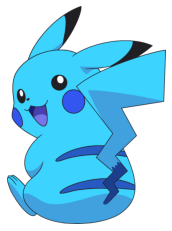

<Figure size 30000x30000 with 0 Axes>

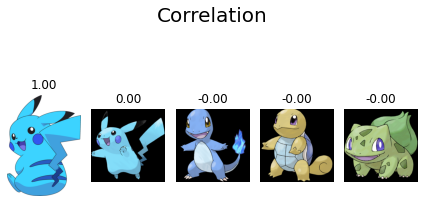

In [168]:
fig = plt.figure("Query")        
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mystery_vs_target_dic["mystery1.png"])
plt.axis("off")
# initialize the results figure
fig=plt.figure(figsize=(200,200),dpi=150)
fig = plt.figure("Results:")
fig.suptitle(m_name[0], fontsize = 20)
for (i, (v, k)) in enumerate(mystery_score["Correlation"]):
        # show the result
    ax = fig.add_subplot(1, len(mystery_vs_target_dic), i + 1)
            
    ax.set_title("%.2f" % ( v))
    plt.imshow(mystery_vs_target_dic[k])
    plt.tight_layout(pad=400)
    plt.axis("off")
    plt.tight_layout()
# show the OpenCV methods
plt.show()